In [1]:
from datetime import time

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import sys
sys.path.append('..')

from tools.siren import *
from tools.table import *

from tools.simulation import create_siren_grid

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
table = Table('cprof_mu_train_10000ev.h5')
table_data = create_siren_grid(table)
siren_model, model_params = load_siren_jax('siren_cprof_mu.pkl')
origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])
Nphot = 5_000_000
key = random.PRNGKey(0)
energy = 500

In [3]:
from functools import partial
from tools.generate import generate_random_cone_vectors, jax_linear_interp, normalize

@partial(jax.jit, static_argnums=(3))
def new_differentiable_get_rays(track_origin, track_direction, energy, Nphot, table_data, model_params, key):
    key, subkey = random.split(key)
    cos_bins, trk_bins, cos_trk_mesh, (x_data, y_data), grid_shape = table_data

    # Create the evaluation grid using JAX operations - using efficient meshgrid
    energy_interp = jax_linear_interp(x_data, y_data, energy)
    cos_mesh, trk_mesh = jnp.meshgrid(cos_bins, trk_bins, indexing='ij')  # Note the indexing='ij'
    evaluation_grid = jnp.stack([
        jnp.full_like(cos_mesh, energy_interp).ravel(),
        cos_mesh.ravel(),  # Maintain correct order: cos first
        trk_mesh.ravel(),  # trk second
    ], axis=1)

    # Initialize SIREN model
    model = SIREN(
        hidden_features=256,
        hidden_layers=3,
        out_features=1,
        outermost_linear=True
    )

    # Apply SIREN model
    photon_weights, _ = model.apply(model_params, evaluation_grid)

    # After getting selected_cos and selected_trk:
    key, sampling_key = random.split(key)
    key, noise_key_cos = random.split(key)
    key, noise_key_trk = random.split(key)

    num_seeds = jnp.int32(energy * 69.77142857 - 11980.42857143)  # using 500 x 500 binning and 0.02  cut-off value

    seed_indices = random.randint(sampling_key, (Nphot,), 0, num_seeds)
    indices_by_weight = jnp.argsort(-photon_weights.squeeze())[seed_indices]

    cos_trk_mesh = jnp.array(cos_trk_mesh)
    selected_cos_trk = cos_trk_mesh[indices_by_weight]

    # Split into separate cos and trk arrays
    sampled_cos = selected_cos_trk[:, 0]
    sampled_trk = selected_cos_trk[:, 1]

    # Add Gaussian noise
    sigma_cos = 0.001
    sigma_trk = 0.001

    noise_cos = random.normal(noise_key_cos, (Nphot,)) * sigma_cos
    noise_trk = random.normal(noise_key_trk, (Nphot,)) * sigma_trk

    smeared_cos = sampled_cos + noise_cos
    smeared_trk = sampled_trk + noise_trk

    # kill those events sampled outside of the normalized SIREN binning
    # the sigma and binning are chosen such that the fraction of those events is negligibly small.
    smeared_trk = jnp.where(smeared_trk < -1, 0, smeared_trk)
    smeared_trk = jnp.where(smeared_trk > 1, 0, smeared_trk)

    smeared_cos = jnp.where(smeared_cos < -1, 0, smeared_cos)
    smeared_cos = jnp.where(smeared_cos > 1, 0, smeared_cos)

    # Create new evaluation grid with smeared values
    energy_interp = jax_linear_interp(x_data, y_data, energy)
    new_evaluation_grid = jnp.stack([
        jnp.full_like(smeared_cos, energy_interp),
        smeared_cos,
        smeared_trk,
    ], axis=1)

    # Run the model with new grid
    new_photon_weights, _ = model.apply(model_params, new_evaluation_grid)

    photon_thetas = jnp.arccos(smeared_cos)

    # Generate ray vectors and origins
    subkey, subkey2 = random.split(subkey)
    ray_vectors = generate_random_cone_vectors(track_direction, photon_thetas, Nphot, subkey)

    # Convert ranges to meters and compute ray origins
    ranges = (smeared_trk * 300 + 300) / 100
    ray_origins = jnp.ones((Nphot, 3)) * track_origin[None, :] + ranges[:, None] * normalize(track_direction[None, :])

    return ray_vectors, ray_origins, jnp.squeeze(new_photon_weights)

In [4]:
# run this once just to compile the function...
Nphot = 10
ray_vectors, ray_origins, photon_weights = new_differentiable_get_rays(origin, direction, energy, Nphot, table_data, model_params, key)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

def benchmark_photon_counts(photon_counts, origin, direction, energy, table_data, model_params, key):
    """
    Benchmark the new_differentiable_get_rays function across different photon counts
    """
    
    results = {
        'photon_counts': [],
        'mean_times': [],
        'std_times': [],
        'all_times': []
    }
    
    print("Benchmarking photon counts:")
    print("-" * 50)
    
    for i, Nphot in enumerate(photon_counts):
        print(f"Testing {Nphot:,} photons ({i+1}/{len(photon_counts)})...")
        
        # Warmup run (important for JAX compiled functions)
        #if i == 0:  # Only warmup on first iteration
        #    #print("  Performing warmup...")
        _ = new_differentiable_get_rays(origin, direction, energy, Nphot, table_data, model_params, key)
        
        # Use IPython's timeit magic to get detailed timing
        timing_result = %timeit -n 100 -r 2 -o ray_vectors, ray_origins, photon_weights = new_differentiable_get_rays(origin, direction, energy, Nphot, table_data, model_params, key)
        
        # Extract metrics
        mean_time = timing_result.average
        std_time = timing_result.stdev
        all_runs = timing_result.all_runs
        
        # Store results
        results['photon_counts'].append(Nphot)
        results['mean_times'].append(mean_time)
        results['std_times'].append(std_time)
        results['all_times'].append(all_runs)
        
        print(f"  Mean: {mean_time:.4f}s ± {std_time:.4f}s")
    
    return results

# Define photon count range (10 points from ~0 to 5 million)
# Starting from 100,000 instead of 0 to avoid edge cases
photon_counts = [1_000, 10_000, 50_000, 100_000, 200_000, 300_000, 400_000, 500_000, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000]#np.logspace(5, np.log10(5_00_000), 5, dtype=int)
print("Photon counts to test:", [f"{n:,}" for n in photon_counts])

# Run the benchmark
results = benchmark_photon_counts(photon_counts, origin, direction, energy, table_data, model_params, key)

Photon counts to test: ['1,000', '10,000', '50,000', '100,000', '200,000', '300,000', '400,000', '500,000', '1,000,000', '2,000,000', '3,000,000', '4,000,000', '5,000,000']
Benchmarking photon counts:
--------------------------------------------------
Testing 1,000 photons (1/13)...
3.19 ms ± 96.6 μs per loop (mean ± std. dev. of 2 runs, 100 loops each)
  Mean: 0.0032s ± 0.0001s
Testing 10,000 photons (2/13)...
3.29 ms ± 84.2 μs per loop (mean ± std. dev. of 2 runs, 100 loops each)
  Mean: 0.0033s ± 0.0001s
Testing 50,000 photons (3/13)...
3.77 ms ± 104 μs per loop (mean ± std. dev. of 2 runs, 100 loops each)
  Mean: 0.0038s ± 0.0001s
Testing 100,000 photons (4/13)...
4.34 ms ± 126 μs per loop (mean ± std. dev. of 2 runs, 100 loops each)
  Mean: 0.0043s ± 0.0001s
Testing 200,000 photons (5/13)...
5.33 ms ± 209 μs per loop (mean ± std. dev. of 2 runs, 100 loops each)
  Mean: 0.0053s ± 0.0002s
Testing 300,000 photons (6/13)...
6.38 ms ± 362 μs per loop (mean ± std. dev. of 2 runs, 100 lo

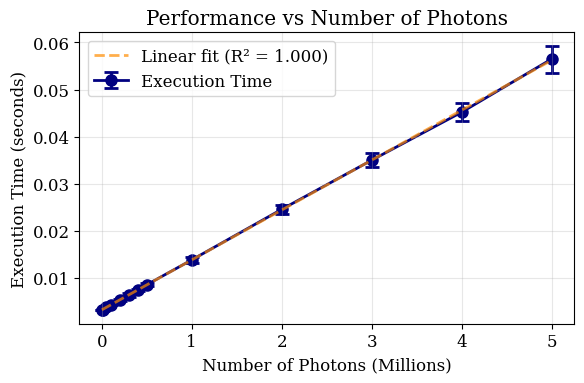

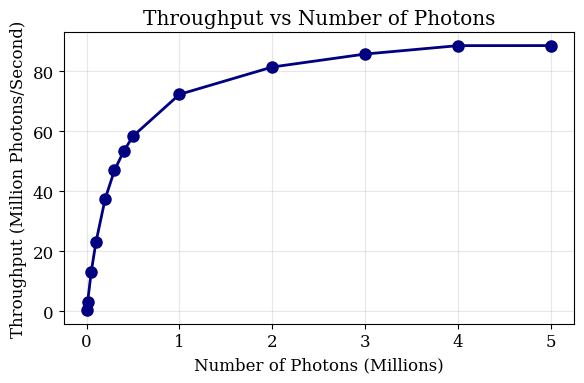


BENCHMARK SUMMARY
Photons      Mean Time (s)   Std Dev (s)  Throughput (M/s)
------------------------------------------------------------
1,000        0.0032          0.0001       0.31           
10,000       0.0033          0.0001       3.04           
50,000       0.0038          0.0001       13.27          
100,000      0.0043          0.0001       23.03          
200,000      0.0053          0.0002       37.55          
300,000      0.0064          0.0004       47.01          
400,000      0.0075          0.0002       53.40          
500,000      0.0086          0.0003       58.40          
1,000,000    0.0138          0.0007       72.30          
2,000,000    0.0246          0.0009       81.41          
3,000,000    0.0350          0.0015       85.73          
4,000,000    0.0452          0.0019       88.53          
5,000,000    0.0565          0.0029       88.55          

Linear scaling coefficient: 1.06e-08 s/photon
Base overhead: 0.0032 s
R-squared: 0.9999


In [6]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

figsize = (6,4)

# Convert to numpy arrays for easier plotting
photon_counts = np.array(results['photon_counts'])
mean_times = np.array(results['mean_times'])
std_times = np.array(results['std_times'])

# Create the plot
plt.figure(figsize=figsize)

# Main plot with error bars
plt.errorbar(photon_counts / 1e6, mean_times, yerr=std_times, 
             marker='o', markersize=8, capsize=5, capthick=2, 
             linewidth=2, label='Execution Time', zorder=-1, color='navy')

plt.xlabel('Number of Photons (Millions)')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance vs Number of Photons')
plt.grid(True, alpha=0.3)
plt.legend()

# Add some styling
plt.tight_layout()

# Optional: Add a linear fit to see scaling behavior
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(photon_counts, mean_times)
fit_line = slope * photon_counts + intercept
plt.plot(photon_counts / 1e6, fit_line, '--', alpha=0.7, color='darkorange', lw=2, 
         label=f'Linear fit (R² = {r_value**2:.3f})')

plt.legend()
plt.show()


# Additional analysis: throughput plot
plt.figure(figsize=figsize)
throughput = (photon_counts / 1e6) / mean_times
plt.plot(photon_counts / 1e6, throughput, 'o-', linewidth=2, markersize=8, color='navy')
plt.xlabel('Number of Photons (Millions)')
plt.ylabel('Throughput (Million Photons/Second)')
plt.title('Throughput vs Number of Photons')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("BENCHMARK SUMMARY")
print("="*60)
print(f"{'Photons':<12} {'Mean Time (s)':<15} {'Std Dev (s)':<12} {'Throughput (M/s)':<15}")
print("-" * 60)

for i, (n_phot, mean_t, std_t) in enumerate(zip(photon_counts, mean_times, std_times)):
    throughput = (n_phot / 1e6) / mean_t
    print(f"{n_phot:<12,} {mean_t:<15.4f} {std_t:<12.4f} {throughput:<15.2f}")

print(f"\nLinear scaling coefficient: {slope:.2e} s/photon")
print(f"Base overhead: {intercept:.4f} s")
print(f"R-squared: {r_value**2:.4f}")



In [7]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import sys
sys.path.append('..')

from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import generate_random_point_inside_cylinder, generate_random_params
from tools.losses import compute_simplified_loss
from tools.simulation import setup_event_simulator

# Configuration
default_json_filename = '../config/IWCD_geom_config.json'
detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)

# Benchmarking parameters
K_VALUES = [1, 2, 3, 4]
N_VALUES = [100000, 250000, 500000, 750000, 1000000, 1500000, 2000000]
WARMUP_RUNS = 10
TIMING_RUNS = 100

def benchmark_simulation(is_calibration=False):
    """Benchmark simulation for different N and K values"""
    results = {k: {'N': [], 'mean_time': [], 'std_time': []} for k in K_VALUES}

    print("Benchmarking simulation performance...")

    for K in K_VALUES:
        print(f"\nK = {K}")

        for Nphot in N_VALUES:
            print(f"  N = {Nphot:,}")

            # Setup simulator
            simulate_event = jit(setup_event_simulator(
                default_json_filename, Nphot, temperature=None, K=K, is_calibration=is_calibration
            ))

            # Initial key
            key = jax.random.PRNGKey(42)

            # Warmup
            for _ in range(WARMUP_RUNS):
                key, subkey = jax.random.split(key)
                # Generate new position each time
                source_origin = generate_random_point_inside_cylinder(subkey, r=4, h=6)
                other_params = (source_origin, 1000)
                track_params = (
                    jnp.array(800.0, dtype=jnp.float32),
                    jnp.array([0.0, 0.0, 0.0], dtype=jnp.float32),
                    jnp.array([jnp.pi/3, jnp.pi/4], dtype=jnp.float32)
                )
                
                if is_calibration == False:
                    other_params = track_params
                
                detector_params = (
                    jnp.array(4.), jnp.array(0.2), jnp.array(6.), jnp.array(0.001)
                )
                
                key, subkey = jax.random.split(key)
                result = simulate_event(other_params, detector_params, subkey)
                jax.tree.map(lambda x: x.block_until_ready(), result)

            # Timing
            times = []
            for _ in range(TIMING_RUNS):
                key, subkey = jax.random.split(key)
                # Generate new position each time
                source_origin = generate_random_point_inside_cylinder(subkey, r=4, h=6)
                other_params = (source_origin, 1000)
                track_params = (
                    jnp.array(800.0, dtype=jnp.float32),
                    jnp.array([0.0, 0.0, 0.0], dtype=jnp.float32),
                    jnp.array([jnp.pi/3, jnp.pi/4], dtype=jnp.float32)
                )
                
                if is_calibration == False:
                    other_params = track_params
                
                detector_params = (
                    jnp.array(4.), jnp.array(0.2), jnp.array(6.), jnp.array(0.001)
                )
            
                key, subkey = jax.random.split(key)
                start = time.time()
                result = simulate_event(other_params, detector_params, subkey)
                jax.tree.map(lambda x: x.block_until_ready(), result)
                times.append(time.time() - start)

            results[K]['N'].append(Nphot)
            results[K]['mean_time'].append(np.mean(times))
            results[K]['std_time'].append(np.std(times))

    return results

def benchmark_gradient(is_calibration=False):
    """Benchmark gradient computation for source and detector parameters"""
    results = {k: {'N': [], 'mean_time': [], 'std_time': []} for k in K_VALUES}

    print("\n\nBenchmarking gradient computation...")

    # Generate true data once with fixed N
    Nphot_true = 100000
    key = jax.random.PRNGKey(42)

    source_origin = generate_random_point_inside_cylinder(key, r=4, h=6)
    other_params = (source_origin, 1000)
    track_params = (
        jnp.array(800.0, dtype=jnp.float32),
        jnp.array([0.0, 0.0, 0.0], dtype=jnp.float32),
        jnp.array([jnp.pi/3, jnp.pi/4], dtype=jnp.float32)
    )
    
    if is_calibration == False:
        other_params = track_params
    
    detector_params = (
        jnp.array(4.), jnp.array(0.2), jnp.array(6.), jnp.array(0.001)
    )

    # Generate true data with fixed simulator
    simulate_true = setup_event_simulator(
        default_json_filename, Nphot_true, temperature=None, K=2, is_calibration=is_calibration
    )
    key, subkey = jax.random.split(key)
    true_data = jax.lax.stop_gradient(simulate_true(other_params, detector_params, subkey))

    for K in K_VALUES:
        print(f"\nK = {K}")

        for Nphot in N_VALUES:
            print(f"  N = {Nphot:,}")

            # Setup simulator for this N
            simulate_event = setup_event_simulator(
                default_json_filename, Nphot, temperature=None, K=K, is_calibration=is_calibration
            )

            # Create loss and gradient function for both source and detector params
            @jit
            def loss_and_grad_fn(other_params, detector_params):
                def loss_fn(s_origin, d_params):
                    #source_params = (s_origin, 1000)
                    simulated_data = simulate_event(other_params, d_params, key)
                    return compute_simplified_loss(detector_points, *true_data, *simulated_data, lambda_time=0.0)
                return value_and_grad(loss_fn, argnums=(0, 1))(source_origin, detector_params)

            # Warmup
            for i in range(WARMUP_RUNS):
                # Generate new position each time
                key, subkey = jax.random.split(key)
                #test_origin = generate_random_point_inside_cylinder(subkey, r=4, h=6)

                source_origin = generate_random_point_inside_cylinder(key, r=4, h=6)
                other_params = (source_origin, 1000)
                
                if is_calibration == False:
                    other_params = generate_random_params(key)
                
                loss_val, (grad_source, grad_detector) = loss_and_grad_fn(other_params, detector_params)
                jax.tree.map(lambda x: x.block_until_ready(), (loss_val, grad_source, grad_detector))

            # Timing
            times = []
            for i in range(TIMING_RUNS):
                # Generate new position each time
                key, subkey = jax.random.split(key)
                #test_origin = generate_random_point_inside_cylinder(subkey, r=4, h=6)

                source_origin = generate_random_point_inside_cylinder(key, r=4, h=6)
                other_params = (source_origin, 1000)
                
                if is_calibration == False:
                    other_params = generate_random_params(key)
                
                start = time.time()
                loss_val, (grad_source, grad_detector) = loss_and_grad_fn(other_params, detector_params)
                jax.tree.map(lambda x: x.block_until_ready(), (loss_val, grad_source, grad_detector))
                times.append(time.time() - start)

            results[K]['N'].append(Nphot)
            results[K]['mean_time'].append(np.mean(times))
            results[K]['std_time'].append(np.std(times))

    return results

sim_results_full = benchmark_simulation(is_calibration=False)
grad_results_full = benchmark_gradient(is_calibration=False)

sim_results_calib = benchmark_simulation(is_calibration=True)
grad_results_calib = benchmark_gradient(is_calibration=True)



# Print summary
print("\n" + "="*50)
print("SUMMARY CALIBRATION")
print("="*50)
print("\nSimulation times (milliseconds):")
for K in K_VALUES:
    print(f"\nK = {K}:")
    for i, N in enumerate(sim_results_calib[K]['N']):
        mean_ms = sim_results_calib[K]['mean_time'][i] * 1000
        std_ms = sim_results_calib[K]['std_time'][i] * 1000
        print(f"  N = {N:>9,}: {mean_ms:.2f} ± {std_ms:.2f} ms")

print("\nGradient computation times (milliseconds):")
for K in K_VALUES:
    print(f"\nK = {K}:")
    for i, N in enumerate(grad_results_calib[K]['N']):
        mean_ms = grad_results_calib[K]['mean_time'][i] * 1000
        std_ms = grad_results_calib[K]['std_time'][i] * 1000
        print(f"  N = {N:>9,}: {mean_ms:.2f} ± {std_ms:.2f} ms")


print("\n" + "="*50)
print("SUMMARY FULL")
print("="*50)
print("\nSimulation times (milliseconds):")
for K in K_VALUES:
    print(f"\nK = {K}:")
    for i, N in enumerate(sim_results_full[K]['N']):
        mean_ms = sim_results_full[K]['mean_time'][i] * 1000
        std_ms = sim_results_full[K]['std_time'][i] * 1000
        print(f"  N = {N:>9,}: {mean_ms:.2f} ± {std_ms:.2f} ms")

print("\nGradient computation times (milliseconds):")
for K in K_VALUES:
    print(f"\nK = {K}:")
    for i, N in enumerate(grad_results_full[K]['N']):
        mean_ms = grad_results_full[K]['mean_time'][i] * 1000
        std_ms = grad_results_full[K]['std_time'][i] * 1000
        print(f"  N = {N:>9,}: {mean_ms:.2f} ± {std_ms:.2f} ms")

Benchmarking simulation performance...

K = 1
  N = 100,000
  N = 250,000
  N = 500,000
  N = 750,000
  N = 1,000,000
  N = 1,500,000
  N = 2,000,000

K = 2
  N = 100,000
  N = 250,000
  N = 500,000
  N = 750,000
  N = 1,000,000
  N = 1,500,000
  N = 2,000,000

K = 3
  N = 100,000
  N = 250,000
  N = 500,000
  N = 750,000
  N = 1,000,000
  N = 1,500,000
  N = 2,000,000

K = 4
  N = 100,000
  N = 250,000
  N = 500,000
  N = 750,000
  N = 1,000,000
  N = 1,500,000
  N = 2,000,000


Benchmarking gradient computation...

K = 1
  N = 100,000
  N = 250,000
  N = 500,000
  N = 750,000
  N = 1,000,000
  N = 1,500,000
  N = 2,000,000

K = 2
  N = 100,000
  N = 250,000
  N = 500,000
  N = 750,000
  N = 1,000,000
  N = 1,500,000
  N = 2,000,000

K = 3
  N = 100,000
  N = 250,000
  N = 500,000
  N = 750,000
  N = 1,000,000
  N = 1,500,000
  N = 2,000,000

K = 4
  N = 100,000
  N = 250,000
  N = 500,000
  N = 750,000
  N = 1,000,000
  N = 1,500,000
  N = 2,000,000
Benchmarking simulation performanc

In [8]:
# Plot results
def plot_results(sim_results, grad_results):
    """Plot both simulation and gradient results"""

    # Use same colors for both plots
    colors = plt.cm.viridis(np.linspace(0, 1, len(K_VALUES)))

    # Simulation timing plot
    plt.figure(figsize=(6, 4))

    for i, K in enumerate(K_VALUES):
        N = np.array(sim_results[K]['N'])
        mean_time = np.array(sim_results[K]['mean_time']) * 1000  # Convert to ms
        std_time = np.array(sim_results[K]['std_time']) * 1000   # Convert to ms

        plt.plot(N, mean_time, 'o-', color=colors[i], label=f'K={K}')
        plt.fill_between(N, mean_time - std_time, mean_time + std_time, alpha=0.3, color=colors[i])

    plt.xlabel('Number of Photons (N)')
    plt.ylabel('Time (ms)')
    plt.title('Simulation Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.tight_layout()
    plt.savefig('../plots/simulation_timing.png', dpi=300)
    plt.show()

    # Gradient timing plot
    plt.figure(figsize=(6, 4))

    for i, K in enumerate(K_VALUES):
        N = np.array(grad_results[K]['N'])
        mean_time = np.array(grad_results[K]['mean_time']) * 1000  # Convert to ms
        std_time = np.array(grad_results[K]['std_time']) * 1000   # Convert to ms

        plt.plot(N, mean_time, 'o-', color=colors[i], label=f'K={K}')
        plt.fill_between(N, mean_time - std_time, mean_time + std_time, alpha=0.3, color=colors[i])

    plt.xlabel('Number of Photons (N)')
    plt.ylabel('Time (ms)')
    plt.title('Gradient Computation Performance\n(Source + Detector Parameters)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.tight_layout()
    plt.savefig('../plots/gradient_timing.png', dpi=300)
    plt.show()

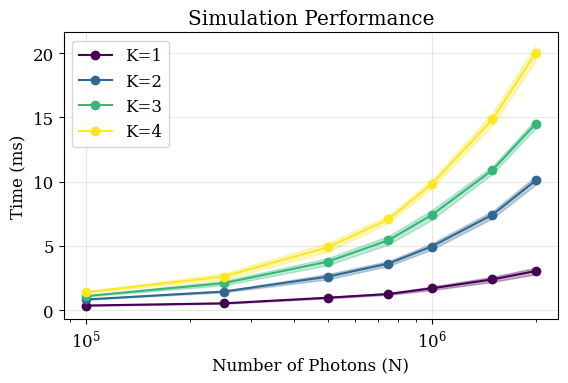

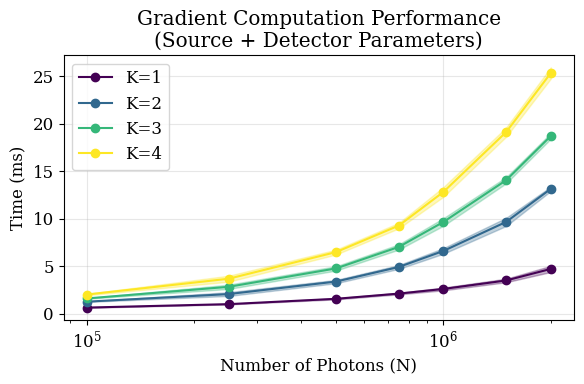

In [9]:
plot_results(sim_results_calib, grad_results_calib)

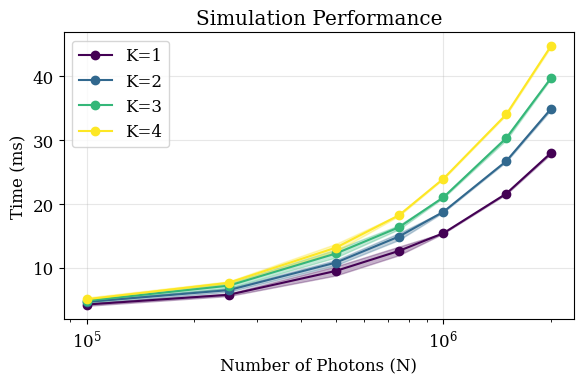

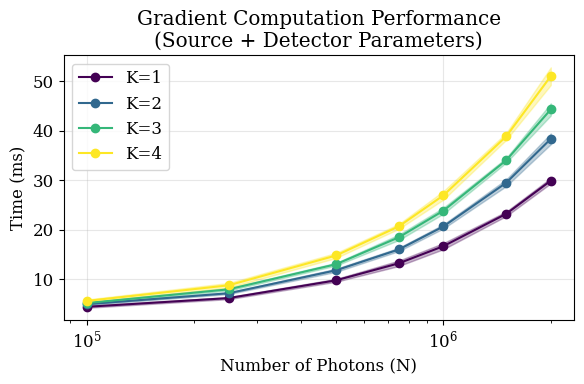

In [10]:
plot_results(sim_results_full, grad_results_full)